In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import gpflow


In [2]:
n_points=1000
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)
x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

y_obs = f + np.random.normal(scale=.1, size=n_points).reshape(n_points, 1)
X=x
y=y_obs

NameError: name 'lt' is not defined

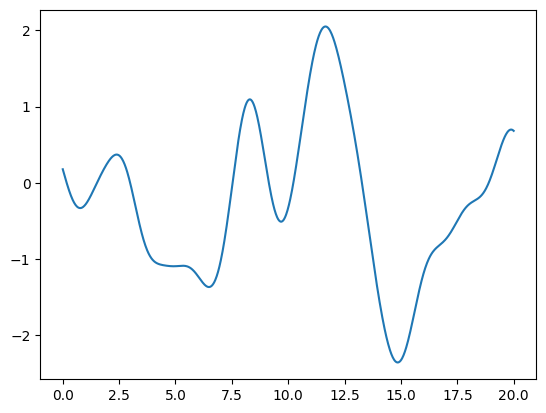

In [3]:
plt.plot(x,f)
lt.plot(x,y_obs)

In [20]:
@tf.function
def update_mu_f(alpha,Sigma_a_inv,J_w_inv,sigma_2,Y_train,mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + 1 / sigma_2)
    q2 = tf.matmul((2  / sigma_2), (Y_train))
    return tf.matmul(q1, q2)



def update_Sigma_f(c_f, K, sigma_2, J_w):
    """
    Compute the updated value of Sigma_f.

    Parameters:
        c_f (float): Scaling constant.
        K (Tensor): Kernel matrix.
        sigma_2 (float): Noise variance.
        J_w (Tensor): Weight matrix.

    Returns:
        Tensor: The updated value of Sigma_f.
    """
    Sigma_f = c_f * K * tf.linalg.inv(K + sigma_2 * J_w / 2) * sigma_2 * J_w / 2
    return Sigma_f

def divide_batch(X,y,test_ratio=0.2,seed=None):
    if seed is None:
        seed=np.random.uniform(0,1000)

    tf.random.set_seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)
    
    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)
    
    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]
    
    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices

def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)

def Full_sample_estimate(variance,lengthscale,X,w_full,c_f,alpha,Y):
    kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(variance,lengthscale)
    K=kernel.matrix(X,X)
    #update quantitites, Sigma_a,J_w
    w_full=sigma/(2**0.5)*w_full
    J_w=tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full,-2)))*sigma**2/2
    J_w_inv=tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full,2)))*2/(sigma**2)
    
    
    
    Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 /2* J_w) * sigma ** 2 / 2) @ J_w
    
    Sigma_a = alpha * K + (1 - alpha) * Sigma_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a)
    
    
    mu_f=update_mu_f(alpha,Sigma_a_inv,J_w_inv,sigma**2,Y,m_w_full)
    return (mu_f,Sigma_f)


In [21]:
sigma=tf.Variable(1.0,dtype=tf.float64,constraint=lambda z: tf.clip_by_value(z, 0.01, 10))
c_f=tf.Variable(1.0,dtype=tf.float64,constraint=lambda z: tf.clip_by_value(z, 0.01, 10),trainable=False)
variance=tf.Variable(1.0,dtype=tf.float64,constraint=lambda z: tf.clip_by_value(z, 0.01, 10))
lengthscale=tf.Variable(1.0,dtype=tf.float64,constraint=lambda z: tf.clip_by_value(z, 0.01, 10))
alpha=tf.Variable(0.0001,dtype=tf.float64,constraint=lambda z: tf.clip_by_value(z,-1, 2),trainable=False)



In [22]:
for i in range(500):
    print(i)
    with tf.GradientTape() as tape:
    with tf.GradientTape() as tape:
         #create batch for the iteration
            X_train, Y_train, X_test, Y_test,train_indices, test_indices = divide_batch(X,y,test_ratio=0.2,seed=1)
            
            #estimate Gpflow kernel.
            kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(variance,lengthscale)
            K=kernel.matrix(X_train,X_train)
        
            
            new_ind=list(train_indices.numpy())
            #update quantitites, Sigma_a,J_w
            
            Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 /2 ) * sigma ** 2 / 2)
            
            Sigma_a = alpha * K + (1 - alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a)
            
            
            mu_f=update_mu_f(alpha,Sigma_a_inv,sigma**2,Y_trai)
            K_star=kernel.matrix(X_test,X_train)
            K_star_star=kernel.matrix(X_test,X_test)
        
            
            mu_p=K_star@tf.linalg.inv(K)@ mu_f
            Sigma_p=(K_star_star-c_f*K_star@ tf.linalg.inv(K + sigma ** 2* J_w)@tf.linalg.matrix_transpose(K_star)+
                     (c_f-1)*K_star@ tf.linalg.inv(K )@tf.linalg.matrix_transpose(K_star))
            
            sigma_p=tf.linalg.diag_part(Sigma_p)
            
            normal=tfp.distributions.Normal(mu_p, sigma_p+sigma**2)
            loss=-tf.reduce_sum(normal.log_prob(Y_test))

NameError: name 'J_w_inv' is not defined

4.501408450704226

'dioporco'